# Livrable 2

## Table des matières
1. [Contexte](#context)
2. [Complexité du problème](#problem-complexity)
3. [Modélisation du problème](#problem-modeling)
    1. [Graphe](#graph)
    2. [Variables de décision](#decision-variables)
    3. [Contraintes](#constraints)
    4. [Fonction économique](#economic-function)
4. [Ant Colony Optimization (ACO)](#aco)
    1. [Implémentation](#aco-impl)
    2. [Statistiques](#aco-stats)
5. [Tabu Search (TS)](#ts)

## Installation des dépendances

In [42]:
%pip install matplotlib
%pip install networkx
%pip install numpy

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


Note: you may need to restart the kernel to use updated packages.



## 1. Contexte <a id="context"></a>

Suite aux problèmes climatiques rencontrés, des efforts sont fournis pour réduire les gaz à effet de serre en réduisant les systèmes de transport.

CesiCDP, une structure déjà bien implantée dans le domaine de la Mobilité Multimodale Intelligente décide de répondre à un appel d'offre d'ADEME (Agence de l’Environnement et de la Maîtrise de l’Energie). Notre étude sera orienté sur l'optimisation des tournées de livraison.

L'objectif est de livrer un ensemble de villes avec des véhicules partant tous du même entrepôt, en minimisant la distance totale parcourue. Cela revient donc à déterminer, en se basant sur la recherche opérationnelle, le chemin dont la distance est la plus courte pour chaque véhicule, en prenant en compte d'éventuelles contraintes supplémentaires, telle que la capacité des véhicules.

## 2. Complexité du problème <a id="problem-complexity"></a>

La classe de complexité du Vehicle Routing Problem (VRP) est NP-difficile. Cela signifie qu'il n'existe aucun algorithme connu capable de résoudre le problème en temps polynomial, et que les meilleurs algorithmes connus nécessitent un temps exponentiel dans le pire des cas.

Nous allons le démontrer à partir de la définition d'une chaîne hamiltonienne. Tout d'abord, un chemin hamiltonien d'un graphe est un chemin qui passe par tous les sommets une fois et une seule. Un cycle hamiltonien est un chemin hamiltonien dont les deux sommets extremités sont identiques. Savoir si un graphe possède un cycle hamiltonien est un problème de décision NP-difficile.  
Un problème classique faisant intervenir une chaîne hamiltonienne est le problème du voyageur de commerce (TSP), puisque son but est de parcourir un ensemble de villes (représentées par des sommets) en ne passant qu'une seule fois par chacune d'entre elles, tout en parcourant une distance minimale. Chaque problème algorithmique pouvant être réduit à un problème de décision (ici celui de l'existence d'une chaîne hamiltonienne), nous pouvons en déduire que le TSP est, lui aussi, NP-difficile.  
De la même manière, le VRP pouvant être réduit au TSP, puisqu'il ne s'agit que d'une version complexifiée de ce dernier, il est également NP-difficile.


Nous avons démontré que le VRP était NP-difficile. Voyons maintenant ce que cela implique dans la manière de le résoudre.  
Nous pourrions tout d'abord utiliser une méthode déterministe, en énumérant par exemple toutes les possibilités du problème et en choisissant la meilleure. Ce genre de méthode nous garantit toujours d'avoir en sortie la solution optimale.  
Cependant, le VRP n'étant pas résolvable en un temps polynomial, les méthodes déterministes ne peuvent le résoudre avec des temps d'exécution qui soient appropriés.  
Par exemple, la résolution d'un problème à 10 nœuds peut prendre environ 3 millisecondes, tandis que celle d'un problème à 20 nœuds peut prendre jusqu'à 77 ans.

C'est pour cette raison que des méthodes métaheuristiques sont utilisées. Il s'agit d'algorithmes pouvant déterminer une solution proche de l'optimal, que nous pourrions considérer commme bonne, sans pour autant être optimale. Il est alors possible de trouver une telle solution en un temps polynomial. Il existe beaucoup de métaheuristiques, telles que la colonie de fourmies (ACO), l'algorithme génétique (GA), le recuit simulé (SA), la recherche tabou (TS), etc., dont les applications varient en fonction du problème. Nous avons pour notre part choisi d'implémenter l'ACO et le TS.

La complexité de la métaheuristique utilisée dépend alors du nombre de clients, du nombre de véhicules et des contraintes et objectifs spécifiques du problème, telle que la capacité d'un véhicule. Ces contraintes et variables vont être étudiées dans la [modélisation du problème](#problem-modeling).

## 3. Modélisation du problème <a id="problem-modeling"></a>
### 3.1 Graphe <a id="graph"></a>

Un bon moyen de représenter le VRP est d'utiliser des graphes, en représentant chaque ville par un sommet et en les reliant par des arêtes de poids représentant la distance qui les sépare.
Pour de très grosses instances, il est plus compliqué de visualiser proprement le problème avec un graphe en raison du nombre de sommets, mais des fonctions d'affichages ont été créées pour visualiser une petite instance et faire des tests.
À noter qu'il est aussi possible d'utiliser un système de coordonnées au lieu d'utiliser des poids sur les arêtes pour représenter les distances.

[[ 0 15 21 13 11  8]
 [15  0 21  9  4  3]
 [21 21  0 14 13 18]
 [13  9 14  0 11  6]
 [11  4 13 11  0  2]
 [ 8  3 18  6  2  0]]


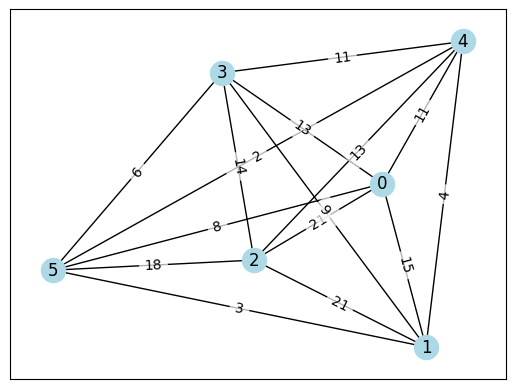

In [43]:
def generate_matrix(node_number):
    G = nx.complete_graph(node_number)
    for u, v in G.edges():
        G.edges[u,v]['weight'] = np.random.randint(1, 25)
    return nx.to_numpy_array(G, dtype=np.int32) # matrix

def draw_graph(matrix):
    G = nx.from_numpy_array(matrix)
    pos = nx.spring_layout(G)
    edge_labels = { (u, v): G.get_edge_data(u, v)['weight'] for u, v in G.edges() }
    nx.draw_networkx(G,pos=pos,with_labels=True, node_color=['lightblue'])
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.show()

distances_matrix = generate_matrix(6)
print(distances_matrix)
draw_graph(distances_matrix)


### 3.2. Variables de décision <a id="decision-variables"></a>
* $x_{ik}$: une variable binaire qui prend la valeur $1$ si le client $i$ est affecté au véhicule $k$, et $0$ sinon.
* $y_{ij}$: une variable binaire qui prend la valeur $1$ s'il existe un lien entre le client $i$ et le client $j$, et $0$ sinon.

### 3.3. Contraintes <a id="constraints"></a>
* **Contrainte de véhicules multiples ($k$ camions) :**
    - Chaque véhicule doit commencer et finir au dépôt : $\sum _{i=1}^n x_{ik} = 1$, où $x_{ik}$ est une variable binaire qui prend la valeur $1$ si le client $i$ est assigné au véhicule $k$, et $0$ sinon.
    - Tous les véhicules doivent commencer et finir au même dépôt : $\sum _{k=1}^m x_{ik} = 1$, où $m$ est le nombre de véhicules.
    - Les itinéraires doivent être réalisables, c'est-à-dire qu'ils doivent satisfaire toutes les contraintes : $\sum _{i \in S, j \notin S} x_{ij} \geq 1$, où $S$ est un sous-ensemble de clients visités par le véhicule $k$.
* **Contraintes de capacité :** Soit $c$ la capacité de transport maximale de chaque véhicule et $d_i$ la demande du client $i$. Alors, pour chaque véhicule $k$, l'inégalité suivante doit être vérifiée : $\sum _{i=1}^n d_i x_{ik} \leq c$, où $x_{ik}$ est une variable binaire qui prend la valeur $1$ si le client $i$ est affecté au véhicule $k$, et $0$ sinon.


### 3.4. Fonction économique <a id="economic-function"></a>
Notre objectif est de minimiser la distance totale nécessaire pour que tous les clients soient servis.
Pour minimiser la distance totale dans le problème d'acheminement des véhicules (VRP), nous pouvons utiliser l'expression mathématique suivante : $\min{\sum _{i=1}^n \sum _{j=1}^n d_{ij} x_{ij}}$ où $d_{ij}$ est la distance entre le client $i$ et le client $j$, et $x_{ij}$ est une variable binaire qui prend la valeur 1 si l'itinéraire comprend une connexion entre le client $i$ et le client $j$, et 0 sinon. La fonction objective vise à minimiser la distance totale parcourue par tous les véhicules en visitant tous les clients. Il s'agit de la fonction objective la plus couramment utilisée dans le VRP, et elle peut être optimisée à l'aide de divers algorithmes, tels que l'algorithme d'économie de Clarke et Wright.

## 4. Ant Colony Optimization (ACO) <a id="aco"></a>
### 4.1. Implémentation <a id="aco-impl"></a>

Le code utilisé est contenu dans le fichier [`ant-colony-optimization.py`](ant-colony-optimization.py).

In [40]:
%run ./ant-colony-optimization.py

Best solution: [[0, 80, 644, 748, 666, 908, 310, 192, 108, 112, 1149, 846, 397, 25, 775, 1111, 1042, 1274, 480, 1036, 285, 337, 1463, 123, 554, 948, 741, 788, 677, 124, 347, 234, 663, 461, 920, 89, 1103, 1216, 1417, 1132, 444, 1399, 1361, 468, 579, 1128, 1434, 599, 44, 219, 204, 292, 47, 913, 366, 1405, 1167, 1110, 1226, 1035, 536, 22, 566, 662, 814, 1392, 240, 547, 916, 669, 1118, 787, 1162, 639, 516, 368, 685, 757, 664, 482, 687, 1135, 186, 842, 1263, 1203, 780, 903, 501, 661, 1008, 864, 795, 5, 750, 1427, 836, 882, 290, 978, 1030, 1056, 445, 147, 12, 1026, 456, 1259, 723, 979, 1320, 886, 1191, 876, 278, 571, 763, 527, 1327, 760, 749, 1391, 1451, 796, 60, 225, 1276, 806, 423, 739, 1183, 442, 200, 1268, 293, 653, 88, 581, 841, 317, 1393, 596, 995, 460, 1043, 981, 117, 860, 1133, 1260, 1169, 264, 798, 279, 370, 561, 469, 1335, 155, 693, 612, 930, 1072, 262, 17, 533, 1051, 115, 1431, 470, 649, 1435, 403, 1326, 544, 459, 692, 163, 137, 883, 1424, 218, 1461, 252, 817, 1383, 243, 184, 853,

### 4.2. Statistiques <a id="aco-stats"></a>

## 5. Tabu Search (TS) <a id="ts"></a>

NB: Le code utilisé est contenu dans le fichier [`tabu-search.py`](tabu-search.py).  
La recherche tabou fonctionne très bien pour de petites instances, mais a plus de mal pour plus de villes. Le principe étant de calculer le meilleur voisinnage pour chaque sommet visité, le temps de calcul augmente vite avec le nombre de sommets dans le graphe. Malgré cela, le principe est bien respecté et des résulats corrects nous sont retournés.

Best solution: [[0, 15, 3, 12, 6, 9, 0], [0, 4, 10, 16, 7, 1, 13, 0], [0, 11, 5, 17, 2, 14, 8, 0]]
Distances matrix: [[ 0 12  7 22  5 15 12 12  6  5 19  8 22  1 21 19 24 22]
 [12  0 20 13 23 17 10  4 24 23 23  5 11  5 23  1 21 23]
 [ 7 20  0 16 12  1 17 20 23 12  9  9  3 24  8 11  7  1]
 [22 13 16  0  7  5 14  9  4 22  4 23  1 14 18 13  4 24]
 [ 5 23 12  7  0  8 17  6  9  5  7 11 21  6  4  5 17 14]
 [15 17  1  5  8  0 21 19  2  2  2  6  7 16 17 11 13 11]
 [12 10 17 14 17 21  0 19 23  1 19  9  1 15  5 16  2  2]
 [12  4 20  9  6 19 19  0 16 20  9 19  4 11  6 14  9 21]
 [ 6 24 23  4  9  2 23 16  0  6  9 17 23 13  3 10 17  7]
 [ 5 23 12 22  5  2  1 20  6  0  1  4  4 22 18 10 11 11]
 [19 23  9  4  7  2 19  9  9  1  0 14 24 22 19  9  7 10]
 [ 8  5  9 23 11  6  9 19 17  4 14  0 12 11 13 23  4 22]
 [22 11  3  1 21  7  1  4 23  4 24 12  0  2 13  8 22  6]
 [ 1  5 24 14  6 16 15 11 13 22 22 11  2  0  4 22 12  7]
 [21 23  8 18  4 17  5  6  3 18 19 13 13  4  0 18  6 19]
 [19  1 11 13  5 11 16 14 10

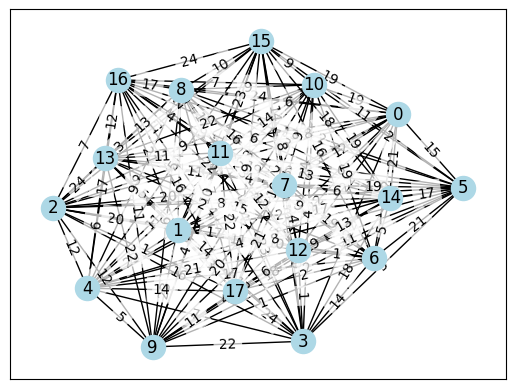

In [41]:
%run ./tabu-search.py